# Pre-selection with resampling convergence (sector-by-sector)

In [7]:
#!pip install pandas pyarrow yfinance fortitudo_tech matplotlib numpy seaborn yfinance

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time

In [120]:
data = pd.read_parquet("merged_portfolio_data.parquet")
data['date'] = pd.to_datetime(data['date'])
data = data.set_index('date')

selected_assets = ['^GSPC','META', 'GOOGL', 'GOOG', 'NFLX', 'DIS', 'CMCSA', 'T', 'VZ', 'TMUS', 'CHTR',
'WBD', 'FOX', 'FOXA', 'OMC', 'IPG', 'EA', 'TTWO', 'ATVI', 'LYV', 'MTCH',
'NWSA', 'NWS', 'NYT', 'PARA', 'TGNA', 'LSXMA', 'TKO']

data = data[[t for t in selected_assets if t in data.columns]]

data_clean = data.dropna(axis=1, how='any')

dropped_assets = set(data.columns) - set(data_clean.columns)
print(f"Assets with full history: {data_clean.shape[1]} / {len(selected_assets)}")
print(f"Dropped (incomplete history): {dropped_assets}")

pnl = np.log(data_clean / data_clean.shift(1)).dropna()

print(f"\nReturns: {pnl.shape[0]} days × {pnl.shape[1]} assets")
print(f"Date range: {pnl.index[0].date()} → {pnl.index[-1].date()}")
print(f"~{len(pnl)/252:.1f} years of daily data")

Assets with full history: 24 / 28
Dropped (incomplete history): {'ATVI', 'WBD'}

Returns: 2470 days × 24 assets
Date range: 2016-01-05 → 2025-11-11
~9.8 years of daily data


In [121]:
B = 10000          
N = 252           
alpha = 0.90      
H = 1            

np.random.seed(42)

print(f"Bootstrap samples: {B}")
print(f"Sample size per bootstrap: {N} days")
print(f"CVaR level: {alpha*100:.0f}%")
print(f"Horizon: {H} days (~{H/21:.1f} months)")
print(f"Available history: {len(pnl)} days")

Bootstrap samples: 10000
Sample size per bootstrap: 252 days
CVaR level: 90%
Horizon: 1 days (~0.0 months)
Available history: 2470 days


In [122]:
def compute_cvar(returns, alpha):
    """Compute CVaR (Expected Shortfall) at alpha confidence level."""
    cutoff = np.percentile(returns, (1 - alpha) * 100)
    tail_returns = returns[returns <= cutoff]
    return tail_returns.mean() if len(tail_returns) > 0 else returns.min()


def compute_efficiency(pnl_sample, H):
    """
    Compute Mean, CVaR, and Efficiency for each asset.
    
    Args:
        pnl_sample: DataFrame of daily log returns (N days × I assets)
        H: Horizon in days
    
    Returns:
        DataFrame with Mean, CVaR, Efficiency per asset
    """
   
    cumulative = pnl_sample.rolling(window=H).sum().dropna()
    
    results = {}
    for asset in cumulative.columns:
        ret = cumulative[asset].values
        mean_ret = ret.mean()
        cvar = compute_cvar(ret, alpha)
        efficiency = mean_ret / (-cvar) if cvar < 0 else np.nan
        
        results[asset] = {
            'Mean': mean_ret,
            'CVaR': cvar,
            'Efficiency': efficiency
        }
    
    return pd.DataFrame(results).T

In [123]:
T = len(pnl)
assets = pnl.columns.tolist()
I = len(assets)

efficiency_matrix = np.full((I, B), np.nan)  
mean_matrix = np.full((I, B), np.nan)
cvar_matrix = np.full((I, B), np.nan)

print(f"Running {B} bootstraps...\n")
t_start = time()

for b in range(B):
    
    max_start = T - N - H 
    start_idx = np.random.randint(0, max_start + 1)
    
    pnl_sample = pnl.iloc[start_idx : start_idx + N + H] 
    
    metrics = compute_efficiency(pnl_sample, H)
    
    efficiency_matrix[:, b] = metrics['Efficiency'].values
    mean_matrix[:, b] = metrics['Mean'].values
    cvar_matrix[:, b] = metrics['CVaR'].values
    
    if (b + 1) % 200 == 0:
        elapsed = time() - t_start
        print(f"  {b+1}/{B} bootstraps | {elapsed:.1f}s")

print(f"\nDone. Total time: {time() - t_start:.1f}s")

Running 10000 bootstraps...

  200/10000 bootstraps | 1.0s
  400/10000 bootstraps | 2.0s
  600/10000 bootstraps | 3.0s
  800/10000 bootstraps | 4.0s
  1000/10000 bootstraps | 5.0s
  1200/10000 bootstraps | 6.0s
  1400/10000 bootstraps | 7.0s
  1600/10000 bootstraps | 8.0s
  1800/10000 bootstraps | 8.9s
  2000/10000 bootstraps | 9.9s
  2200/10000 bootstraps | 10.9s
  2400/10000 bootstraps | 11.8s
  2600/10000 bootstraps | 12.8s
  2800/10000 bootstraps | 13.8s
  3000/10000 bootstraps | 14.8s
  3200/10000 bootstraps | 15.8s
  3400/10000 bootstraps | 16.7s
  3600/10000 bootstraps | 17.7s
  3800/10000 bootstraps | 18.7s
  4000/10000 bootstraps | 19.6s
  4200/10000 bootstraps | 20.6s
  4400/10000 bootstraps | 21.6s
  4600/10000 bootstraps | 22.5s
  4800/10000 bootstraps | 23.5s
  5000/10000 bootstraps | 24.5s
  5200/10000 bootstraps | 25.5s
  5400/10000 bootstraps | 26.5s
  5600/10000 bootstraps | 27.5s
  5800/10000 bootstraps | 28.4s
  6000/10000 bootstraps | 29.4s
  6200/10000 bootstraps |

In [124]:
efficiency_running_mean = np.full((I, B), np.nan)

for b in range(B):
    efficiency_running_mean[:, b] = np.nanmean(efficiency_matrix[:, :b+1], axis=1)

final_mean_eff = np.nanmean(efficiency_matrix, axis=1)
top_k = 10
top_idx = np.argsort(final_mean_eff)[::-1][:top_k]
top_names = [assets[i] for i in top_idx]

print(f"Top {top_k} assets by mean efficiency:")
for i, idx in enumerate(top_idx):
    print(f"  {i+1}. {assets[idx]}: {final_mean_eff[idx]:.4f}")

Top 10 assets by mean efficiency:
  1. TKO: 0.0397
  2. NFLX: 0.0341
  3. ^GSPC: 0.0339
  4. TMUS: 0.0315
  5. LYV: 0.0294
  6. META: 0.0289
  7. GOOG: 0.0278
  8. GOOGL: 0.0272
  9. NYT: 0.0265
  10. TTWO: 0.0261


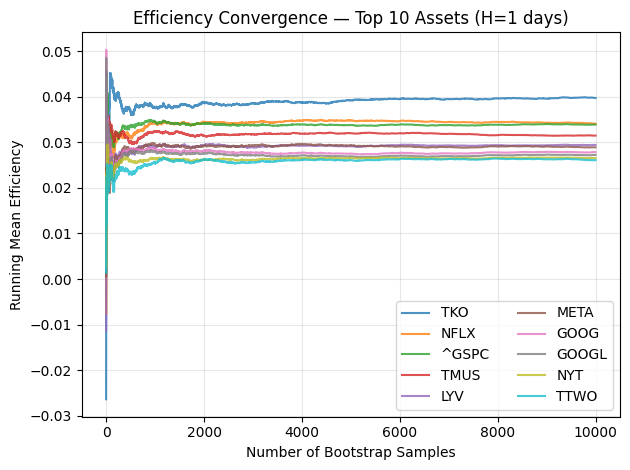

In [125]:
plt.figure()
for i, idx in enumerate(top_idx):
    plt.plot(efficiency_running_mean[idx, :], label=top_names[i], alpha=0.8)

plt.xlabel('Number of Bootstrap Samples')
plt.ylabel('Running Mean Efficiency')
plt.title(f'Efficiency Convergence — Top {top_k} Assets (H={H} days)')
plt.legend(loc='lower right', ncol=2)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [126]:
summary = pd.DataFrame({
    'Mean_Eff': np.nanmean(efficiency_matrix, axis=1),
    'Median_Eff': np.nanmedian(efficiency_matrix, axis=1),
    'Std_Eff': np.nanstd(efficiency_matrix, axis=1),
    'Min_Eff': np.nanmin(efficiency_matrix, axis=1),
    'Max_Eff': np.nanmax(efficiency_matrix, axis=1),
    'Mean_Ret': np.nanmean(mean_matrix, axis=1) * 100,  
    'Mean_CVaR': np.nanmean(cvar_matrix, axis=1) * 100, 
}, index=assets)


summary['Stability'] = summary['Mean_Eff'] / summary['Std_Eff']

summary = summary.sort_values('Mean_Eff', ascending=False)

print(f"Top 20 by Mean Efficiency (H={H} days, B={B} bootstraps):\n")
print(summary.head(20).round(4).to_string())

Top 20 by Mean Efficiency (H=1 days, B=10000 bootstraps):

       Mean_Eff  Median_Eff  Std_Eff  Min_Eff  Max_Eff  Mean_Ret  Mean_CVaR  Stability
TKO      0.0397      0.0282   0.0548  -0.0573   0.2313    0.1026    -3.7974     0.7250
NFLX     0.0341      0.0393   0.0411  -0.0640   0.1204    0.1043    -4.3873     0.8283
^GSPC    0.0339      0.0300   0.0334  -0.0320   0.1374    0.0482    -2.0143     1.0142
TMUS     0.0315      0.0264   0.0319  -0.0367   0.1568    0.0787    -2.7420     0.9864
LYV      0.0294      0.0314   0.0326  -0.0441   0.1033    0.0785    -4.1399     0.9025
META     0.0289      0.0290   0.0418  -0.0671   0.1553    0.0775    -4.0594     0.6913
GOOG     0.0278      0.0273   0.0311  -0.0496   0.1111    0.0748    -3.2305     0.8948
GOOGL    0.0272      0.0267   0.0307  -0.0497   0.1112    0.0733    -3.2301     0.8871
NYT      0.0265      0.0260   0.0309  -0.0551   0.1197    0.0695    -3.2607     0.8594
TTWO     0.0261      0.0210   0.0401  -0.0552   0.1485    0.0751    -3.